In [1]:
import pandas as pd
import numpy as np
import matplotlib
import tensorflow as tf
import os
import matplotlib.pyplot as plt 

In [2]:
os.getcwd()

'/data/home/lmx/psy_test/Github_MentalAId'

In [3]:
os.chdir('/data/home/lmx/psy_test/Github_MentalAId')

In [4]:
data = pd.read_csv('example_data.csv', index_col='Unnamed: 0')
data.reset_index(drop=True, inplace=True)

In [5]:
data.iloc[0:5,0:5]

,A/G,ALB,ALP,ALT,apoA
0,1.83,42.0,30.0,19.0,1.51
1,1.36,42.6,59.0,14.0,1.48
2,0.76,24.8,119.0,11.2,0.74
3,1.66,42.8,52.0,22.0,1.07
4,1.80,46.5,112.0,30.0,1.04


In [6]:
sum_data = pd.read_csv('sum_data.csv', index_col='Unnamed: 0')

In [7]:
sum_data.iloc[0:5,:]

,mean,sd,mean-2*sd,mean+2*sd,min_fin,max_fin
A/G,1.530264,0.311049,0.908167,2.152361,0.908167,2.152361
ALB,41.726301,4.663751,32.398799,51.053803,32.398799,51.053803
ALP,82.506755,55.985144,-29.463532,194.477043,11.000000,194.477043
ALT,28.223439,58.841374,-89.459308,145.906186,3.000000,145.906186
apoA,1.287116,0.301230,0.684656,1.889576,0.684656,1.889576


### Detect missing values and replace (missing values <=3)

In [8]:
data.iloc[:, 0:49] = data.iloc[:, 0:49].apply(pd.to_numeric, errors='coerce')

In [9]:
if data.isna().values.any():
# replace missing values with 0
    data.fillna(0, inplace=True)

In [10]:
# Check for missing values

# Detect number of missing values in each row
detect_na = data.iloc[:, 0:49].apply(lambda x: np.sum(x == 0), axis=1).to_frame()
detect_na.columns = ['number of NA']

# Identify indices of rows with more than 3 missing values
ind_rm = detect_na[detect_na['number of NA'] > 3].index

ind_impute = detect_na[(detect_na['number of NA'] > 0) & (detect_na['number of NA'] < 4)].index
print(f'The following records contain less than 3 missing tests:\n{list(ind_impute)}\nRequire imputation')

if len(ind_rm)>0:
    print(f'The following records contain more than 3 missing tests:\n{ind_rm.item()}\nRemove')

# Remove rows with more than 3 missing values
data = data.drop(ind_rm)

The following records contain less than 3 missing tests:
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Require imputation


In [11]:
data[0:4]

,A/G,ALB,ALP,ALT,apoA,apoB,AST,AST/ALT,Ca,CHO,...,NEU%,PCT,PDW,PLT,RBC,RDW-CV,WBC,Sex,Age,dig
0,1.83,42.0,30.0,19.0,1.51,0.89,16,0.84,2.38,4.97,...,65.9,0.22,12.5,203,4.36,12.1,7.90,0,39,N
1,1.36,42.6,59.0,14.0,1.48,1.01,14,1.00,2.31,5.55,...,51.0,0.28,11.7,272,4.80,12.4,6.06,0,36,N
2,0.76,24.8,119.0,11.2,0.74,0.66,22,1.96,2.03,3.66,...,69.9,0.21,9.0,232,2.91,14.4,5.72,1,86,N
3,1.66,42.8,52.0,22.0,1.07,0.76,16,0.73,2.36,4.09,...,64.7,0.31,12.6,310,5.76,16.4,6.21,1,46,N


In [12]:
for i in range(data.shape[0]):
    for j in range(49):
        if data.iloc[i, j] == 0:
            data.iloc[i, j] = sum_data.iloc[j, 0]

### Feature clipping

In [13]:
for i in range(len(data)):
    for j in range(49):
        data.iloc[i, j] = max(min(data.iloc[i, j], sum_data.iloc[j, 5]),sum_data.iloc[j, 4])

### Data normalization

In [14]:
for i in range(len(data)):
    for j in range(49):
        data.iloc[i, j] = (data.iloc[i, j]-sum_data.iloc[j, 4])/(sum_data.iloc[j, 5]-sum_data.iloc[j, 4])

### Convert data

In [15]:
position = np.load('Feature_position.npy', allow_pickle=True)

In [16]:
position = position.flatten()

In [17]:
fmap_shape = (7,7)
m,n = fmap_shape

In [18]:
data_test = data.iloc[:, 0:49]

In [19]:
a1 = np.array(data_test.columns)

In [20]:
col_asses = np.array([np.where(position== item)[0][0] for item in a1])

In [21]:
col_asses

array([35, 42, 39, 40, 47, 27, 33, 38, 43, 41, 32, 25, 44, 30,  8,  9, 31,
       36, 10, 48,  0, 29, 26, 34, 12, 37, 46,  1, 20, 28, 15, 23, 11, 22,
       14,  7, 45,  3,  2,  4, 18, 17,  6, 13, 16, 19, 21, 24,  5])

In [22]:
nrow = data_test.index.size
x_data = []

for i in range(nrow):
    rec = np.array(data_test.iloc[i,:])
    empty = np.zeros(fmap_shape, dtype='O').reshape(m*n,)
    empty[col_asses] = rec
    rec = empty.reshape(7,7)
    x_data.append(rec)

x_data = np.array(x_data)

In [23]:
x_data.shape

(60, 7, 7)

In [24]:
from tensorflow.keras.utils import to_categorical
num_classes = 2
y_data = np.array(data['dig'])
y_data[y_data == 'N'] = 0
y_data[y_data == 'P'] = 1
y_data = to_categorical(y_data, num_classes)

In [25]:
y_data.shape

(60, 2)

In [26]:
np.unique(y_data, axis=0, return_counts=True)

(array([[0., 1.],
        [1., 0.]], dtype=float32),
 array([25, 35]))

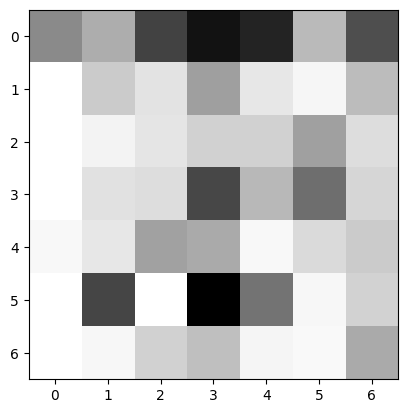

In [27]:
b = np.around(x_data[2].astype('float32'),4)
plt.imshow(b, cmap="Greys")

In [28]:
np.save('x_data.npy', x_data)
np.save('y_data.npy', y_data)  